## Linear Programming Algorithm for the Constrained Knapsack Problem, HGP

## Packages needed

In [11]:
using JuMP
using HiGHS
using Plots

## Draw function

In [64]:
"""
Functionality: draws the optimal path that collects all items from the optimal solution

#### Input:
    coord - coordinates of the items in the problem
    valueX - matrix nxn with binary entries that indicates if the edge ij is in the optimal path;
    a - matrix nx1 that with binary entries indicates which items are in the optimal solution.
    dimx, dimy - dimensions of the map in the x and y axis respectively

#### Output:
    Returns an image that contains the optimal path and all the items displayed in a cartesian plane.

"""
function draw(coord, valueX, a, dimx, dimy)
    m = length(a)
    
    vertices = [0]
    
    for i in 1:length(a)
        if a[i] == 1
            append!(vertices, i)
        end
    end
    
    n = length(vertices)
    
    x = []

    for i in 1:length(coord)
        append!(x,coord[i][1])
    end

    y = []

    for i in 1:length(coord)
        append!(y,coord[i][2])
    end

    sct = scatter(x,y, title = "Optimal path", label = "", color = :blue3
    , gridcolor=:black, gridwidth=1, gridalpha =0.1
    , m = (:circle, 6, stroke(0)))
    
    annotate!(x, y.+0.1, text.(0:(length(x)-1), :bottom, 9))
    
    # drawing the map and the arrows
    
     plot!(sct 
    , xticks = ([-0.5:1:(dimx-0.5);])
    , x_foreground_color_text = :white
    , yticks = ([-0.5:1:(dimy-0.5);])
    , y_foreground_color_text = :white
    , axis = false)
    
     
    for i in 1:m+1 
        for j in 1:m+1 
            if valueX[i,j] >= 0.9 && j != 1
                plot!([coord[i][1], coord[j][1]], [coord[i][2], coord[j][2]]
                , color = :orange, arrow = :arrow, lw = 2, label = "")
            end
        end
    end
    
    display(sct)
    
end

draw

In [65]:
?draw

search: draw RoundNearestTiesAway dirname isdirpath deg2rad deuteranopic



Functionality: draws the optimal path that collects all items from the optimal solution

#### Input:

```
coord - coordinates of the items in the problem
valueX - matrix nxn with binary entries that indicates if the edge ij is in the optimal path;
a - matrix nx1 that with binary entries indicates which items are in the optimal solution.
dimx, dimy - dimensions of the map in the x and y axis respectively
```

#### Output:

```
Returns an image that contains the optimal path and all the items displayed in a cartesian plane.
```


## HGPLP function

In [5]:
"""
Functionality: given a colection of items alongside their weigth and survival value, optimize the total value obtained collecting a
subset of the set of items under time and capacity constraints

#### Input:
    capacity - value in units of weight of the capacity of the knapsack;
    time - value in units of time of the time limit;
    coord - matrix nx1 containing the coordinates of each item;
    s - matrix nx1 containig the survival value of each item;
    p - matrix nx1 containig the weight of each item.

#### Output:
    totaltime - time taken to collect the items of the optimal solution;
    items - items of the optimal set of items;
    constraints - number of constraints of the LP;
    path - an image of the optimal path;
    a - nx1 binary vector containing which items are present in the optimal solution

"""
function HGPLP(capacity, time, coord, s, p)
    
    n = length(s)
    
    constraints = 4
    
    function dist(x, y)
        d = abs(x[1] - y[1]) + abs(x[2] - y[2])
        return d
    end
    
    C = zeros((n+1,n+1))

    for i in 1:length(coord)
        for j in 1:length(coord)
            C[i,j] = dist(coord[i],coord[j])
        end
    end

    model = Model(
           optimizer_with_attributes(HiGHS.Optimizer, "output_flag" => false),
       )

    @variable(model, a[i = 1:n], Bin)
    @variable(model, x[i = 1:n+1, j = 1:n+1], Bin)
    @variable(model, u[j = 2:n+1] >= 0)
    @objective(model, Max, s' * a)
    @constraint(model, weight, p' * a <= capacity)
    @constraint(model, leaveO, sum(x[1,k] for k in 2:n+1) == 1)
    @constraint(model, enterO, sum(x[k,1] for k in 2:n+1) == 1)
    @constraint(model, sum(C[i,j]x[i,j] for i in 1:n+1 for j in 1:n+1 if j != i) - 
        sum(C[i,1]x[i,1] for i in 1:n+1 if i != 1) <= time)
    @constraint(model, leaveitem[k = 1:n], sum(x[k+1,j] for j in 1:(n+1) if j != k+1) == a[k])
    @constraint(model, enteritem[k = 1:n], sum(x[j,k+1] for j in 1:(n+1) if j != k+1) == a[k])
    @constraint(model, subroutes[i = 2:n+1, j = 2:n+1; i != j], u[i] - u[j] + (n+1)*x[i,j] <= (n+1) - 1)
    
    optimize!(model)

    path = value.(x)

    a = value.(a)
    
    totaltime = sum(C[i,j]value(x[i,j]) for i in 1:n+1 for j in 1:n+1 if j != i) - 
        sum(C[i,1]value(x[i,1]) for i in 1:n+1 if i != 1)
    
    items = []
    
    for i in 1:length(a)
        if a[i] >= 0.99999
            append!(items, i)
        end
    end
    
    survival = objective_value(model)
    
    constraints = num_constraints(model; count_variable_in_set_constraints = false)

    return totaltime, items, survival, constraints, path, a
end

HGPLP

In [6]:
?HGPLP

search: HGPLP Highs_passLp kHighsPresolveStatusOptionsError



Functionality: given a colection of items alongside their weigth and survival value, optimize the total value obtained collecting a subset of the set of items under time and capacity constraints

#### Input:

```
capacity - value in units of weight of the capacity of the knapsack;
time - value in units of time of the time limit;
coord - matrix nx1 containing the coordinates of each item;
s - matrix nx1 containig the survival value of each item;
p - matrix nx1 containig the weight of each item.
```

#### Output:

```
totaltime - time taken to collect the items of the optimal solution;
items - items of the optimal set of items;
constraints - number of constraints of the LP;
path - an image of the optimal path;
a - nx1 binary vector containing which items are present in the optimal solution
```


## Problem data

In [7]:
# position of items
coord = [[0,0], [7,8], [2,12], [4,1], [14,12], [12,6], [13,3], [9,4], [10,10], [7,2], [3,4], [2,1], [1,7], [4,8]
        , [0,1], [10,14], [5,6], [14,13], [8,6], [6,12], [11,1]]

# survival value
S = [15; 14; 10; 25; 15; 3; 30; 5; 7; 15; 10; 9; 2; 50; 5; 12; 10; 2; 2; 25]

# weight
P = [9; 5; 3; 10; 10; 10; 15; 3; 3; 5; 5; 6; 1; 25; 7; 5; 4; 1; 2; 12]

20-element Vector{Int64}:
  9
  5
  3
 10
 10
 10
 15
  3
  3
  5
  5
  6
  1
 25
  7
  5
  4
  1
  2
 12

In [8]:
@time HGPLP(30, 30, coord, S, P)[3]
path = HGPLP(30, 30, coord, S, P)[5]
a = HGPLP(30, 30, coord, S, P)[6]

 11.646079 seconds (27.31 M allocations: 1.579 GiB, 4.61% gc time, 98.26% compilation time)


20-element Vector{Float64}:
 0.0
 0.0
 1.0
 1.0
 0.0
 0.0
 0.0
 1.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 1.0
 1.0
 0.0
 0.0
 0.0

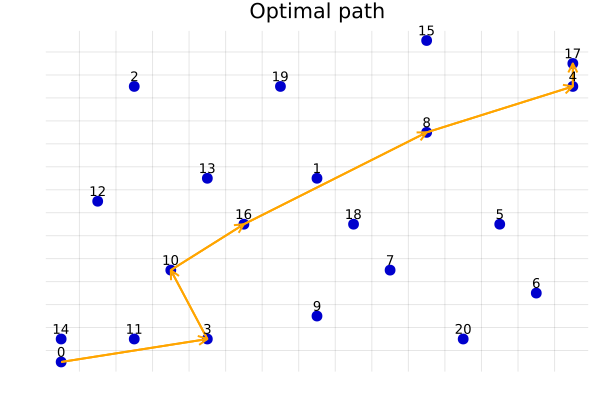

In [66]:
draw(coord, path, a, 15, 15)